<a href="https://colab.research.google.com/github/RastogiShlagha/Projects/blob/master/Structural_Breaks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Chow's Test

In [1]:
import numpy as np
import pandas as pd

df = pd.read_csv("/content/financial_time_series.csv")
print(df.shape)
df.head()

(87, 3)


,Year,LogEqPrem,BookMarket
0,1927,0.280823,0.374689
1,1928,0.313824,0.259667
2,1929,-0.112428,0.338458
3,1930,-0.288025,0.554745
4,1931,-0.563742,1.170732


In [0]:
# Taking one set from (-)inf-->1980
x1 = df[df['Year'] < 1980]['BookMarket']
y1 = df[df['Year'] < 1980]['LogEqPrem']

# Taking another set from 1980-->(+)inf
x2 = df[df['Year'] >= 1980]['BookMarket']
y2 = df[df['Year'] >= 1980]['LogEqPrem']

In [3]:
!git clone https://github.com/jtloong/chow-test.git
%cd chow-test
!pip install .

fatal: destination path 'chow-test' already exists and is not an empty directory.
/content/chow-test
Processing /content/chow-test
  Created wheel for chow-test: filename=chow_test-1.0-cp36-none-any.whl size=1992 sha256=ee54850e0f74db32fc9d1143cdb5d0debd9535b7202e77bbbc2c2d2834955bc4
  Stored in directory: /root/.cache/pip/wheels/db/11/39/c6433d50552b1078edf50e95d142bb4c9d9e2854127e648358
Successfully built chow-test
  Found existing installation: chow-test 1.0
    Uninstalling chow-test-1.0:
      Successfully uninstalled chow-test-1.0


In [5]:
import chow_test

# Don't execute this command--> (Did just for experiment)
f_test = chow_test.f_value(x1, y1, x2, y2)
print(f_test)

[18.3842993]


In [6]:
f_test = chow_test.f_value(y1, x1, y2, x2)
print(f_test)

[2.26875635]


In [7]:
p_val = chow_test.p_value(y1, x1, y2, x2)
print(p_val)

0.10981999864729783


Modelling

In [0]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error, mean_absolute_error
plt.style.use('fivethirtyeight')

In [2]:
import numpy as np
import pandas as pd

pjme = pd.read_csv("/content/financial_time_series.csv", index_col=[0], parse_dates=[0])
print(pjme.shape)
pjme.head()

(87, 2)


,LogEqPrem,BookMarket
Year,,
1927-01-01,0.280823,0.374689
1928-01-01,0.313824,0.259667
1929-01-01,-0.112428,0.338458
1930-01-01,-0.288025,0.554745
1931-01-01,-0.563742,1.170732


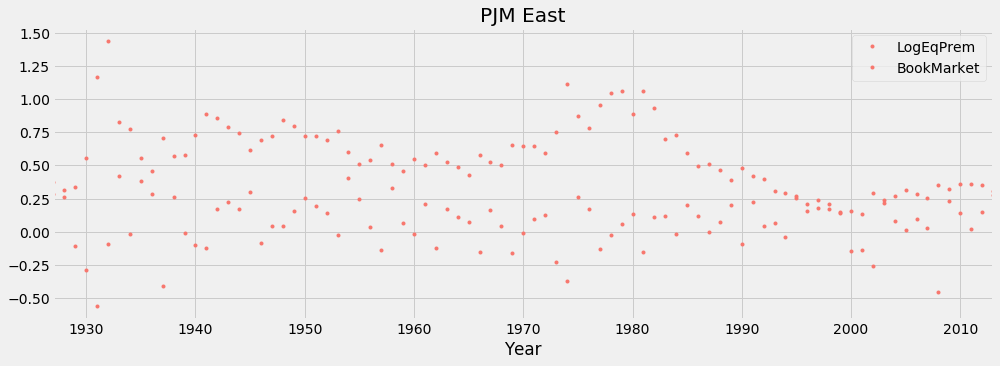

In [3]:
color_pal = ["#F8766D", "#D39200", "#93AA00", "#00BA38", "#00C19F", "#00B9E3", "#619CFF", "#DB72FB"]
_ = pjme.plot(style='.', figsize=(15,5), color=color_pal[0], title='PJM East')

In [0]:
def split_data(data, split_date):
    return data[data.index <= split_date].copy(), \
           data[data.index >  split_date].copy()

In [0]:
train, test = split_data(pjme, '1990')

In [8]:
train

,LogEqPrem,BookMarket
Year,,
1927-01-01,0.280823,0.374689
1928-01-01,0.313824,0.259667
1929-01-01,-0.112428,0.338458
1930-01-01,-0.288025,0.554745
1931-01-01,-0.563742,1.170732
...,...,...
1986-01-01,0.116250,0.498431
1987-01-01,-0.000989,0.508812
1988-01-01,0.073728,0.465284


In [0]:
def create_features(df):
    """
    Creates time series features from datetime index
    """
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.weekofyear
    
    X = df[['hour','dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear']]
    return X


In [0]:
X_train, y_train = create_features(train), train['BookMarket']
X_test, y_test   = create_features(test), test['BookMarket']

In [11]:
X_train

,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear
Year,,,,,,,,
1927-01-01,0,5,1,1,1927,1,1,52
1928-01-01,0,6,1,1,1928,1,1,52
1929-01-01,0,1,1,1,1929,1,1,1
1930-01-01,0,2,1,1,1930,1,1,1
1931-01-01,0,3,1,1,1931,1,1,1
...,...,...,...,...,...,...,...,...
1986-01-01,0,2,1,1,1986,1,1,1
1987-01-01,0,3,1,1,1987,1,1,1
1988-01-01,0,4,1,1,1988,1,1,53


In [12]:
y_train

Year
1927-01-01    0.374689
1928-01-01    0.259667
1929-01-01    0.338458
1930-01-01    0.554745
1931-01-01    1.170732
                ...   
1986-01-01    0.498431
1987-01-01    0.508812
1988-01-01    0.465284
1989-01-01    0.390455
1990-01-01    0.484497
Name: BookMarket, Length: 64, dtype: float64

In [13]:
reg = xgb.XGBRegressor(n_estimators=1000)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        early_stopping_rounds=50, #stop if 50 consequent rounds without decrease of error
        verbose=False) # Change verbose to True if you want to see it train

/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[06:30:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=1000,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

In [0]:
y_pred = reg.predict(X_test)

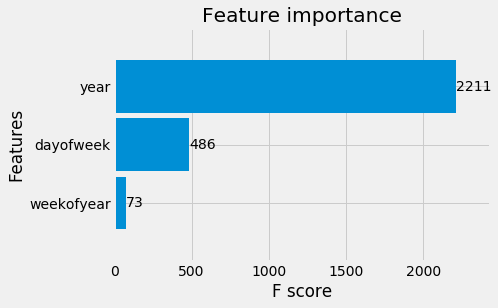

In [16]:
xgb.plot_importance(reg, height=0.9)

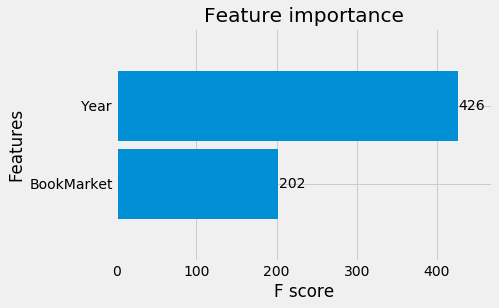

In [0]:
xgb.plot_importance(reg, height=0.9)

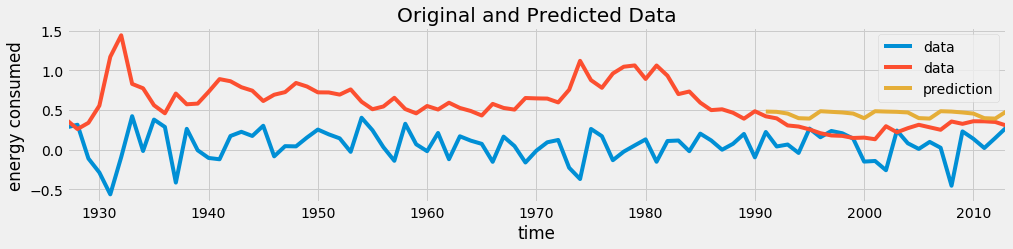

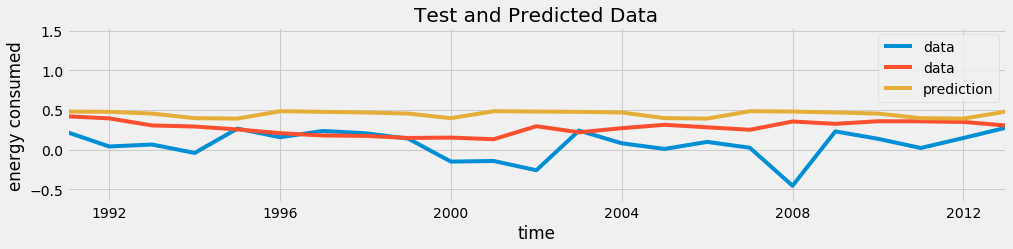

In [17]:
def plot_performance(base_data, date_from, date_to, title=None):
    plt.figure(figsize=(15,3))
    if title == None:
        plt.title('From {0} To {1}'.format(date_from, date_to))
    else:
        plt.title(title)
    plt.xlabel('time')
    plt.ylabel('energy consumed')
    plt.plot(pjme.index,pjme, label='data')
    plt.plot(X_test.index,X_test_pred, label='prediction')
    plt.legend()
    plt.xlim(left=date_from, right=date_to)
X_test_pred = reg.predict(X_test)
    
plot_performance(pjme, pjme.index[0].date(), pjme.index[-1].date(),
                 'Original and Predicted Data')

plot_performance(y_test, y_test.index[0].date(), y_test.index[-1].date(),
                 'Test and Predicted Data')



plt.legend()

plt.show()


In [18]:
mean_squared_error(y_true=y_test,
                   y_pred=X_test_pred)

0.03864184717299937

In [19]:
mean_absolute_error(y_true=y_test,
                   y_pred=X_test_pred)

0.17405322610765142

In [0]:
def mean_absolute_percentage_error(y_true, y_pred): 
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [21]:
mean_absolute_percentage_error(y_test,X_test_pred)

81.93612927605443

In [22]:
error_by_week = []
random_weeks = X_test[['year', 'weekofyear']].sample(10)
for week in random_weeks.iterrows():
    index = (X_test.year == week[1].year) & \
            (X_test.weekofyear == week[1].weekofyear)
    error_by_week.append(mean_absolute_percentage_error(y_test[index], X_test_pred[index]))
pd.Series(error_by_week, index=random_weeks.index)

Year
2009-01-01    44.025553
1992-01-01    20.947283
2010-01-01    27.035503
2008-01-01    35.252945
2011-01-01    11.088190
2002-01-01    62.542161
2013-01-01    57.724639
1995-01-01    53.616282
2007-01-01    93.398448
2004-01-01    73.249814
dtype: float64

In [23]:
X_test['BookMarket'] = y_test
X_test['Prediction'] = X_test_pred
X_test['error'] = y_test - X_test_pred
X_test['abs_error'] = X_test['error'].apply(np.abs)
error_by_day = X_test.groupby(['year','month','dayofmonth']) \
   .mean()[['BookMarket','Prediction','error','abs_error']]

error_by_day.sort_values('error', ascending=True).head(10)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,,,BookMarket,Prediction,error,abs_error
year,month,dayofmonth,,,,
2001,1,1,0.131218,0.484624,-0.353406,0.353406
1999,1,1,0.147167,0.454915,-0.307747,0.307747
1997,1,1,0.178801,0.476665,-0.297864,0.297864
1998,1,1,0.173611,0.468847,-0.295236,0.295236
1996,1,1,0.207343,0.484624,-0.277281,0.277281
2003,1,1,0.218740,0.476665,-0.257925,0.257925
2000,1,1,0.151852,0.396843,-0.244992,0.244992
2007,1,1,0.250583,0.484624,-0.234041,0.234041
2004,1,1,0.270619,0.468847,-0.198228,0.198228


In [24]:
error_by_day.sort_values('abs_error', ascending=True).head(10)

,,,BookMarket,Prediction,error,abs_error
year,month,dayofmonth,,,,
2011,1,1,0.357233,0.396843,-0.039611,0.039611
2012,1,1,0.349032,0.391762,-0.042730,0.042730
1991,1,1,0.420344,0.480127,-0.059782,0.059782
1992,1,1,0.394110,0.476665,-0.082555,0.082555
2005,1,1,0.313478,0.397835,-0.084357,0.084357
2010,1,1,0.358100,0.454915,-0.096814,0.096814
1994,1,1,0.291568,0.396843,-0.105275,0.105275
2006,1,1,0.281682,0.391762,-0.110080,0.110080
2008,1,1,0.354984,0.480127,-0.125142,0.125142
